<font size="5"> Data Manipulation using DASK and Causal Inference using Diff-in-Diff approach

In [31]:
import requests, json, time, statistics, aiohttp, pandas as pd, numpy as np, altair as alt
import statsmodels.api as sm, statsmodels.formula.api as smf
from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
from numpy.fft import fft,fftfreq

# DASK
import dask.array as da
import dask.dataframe as dd
import dask.bag as bag
from dask.distributed import LocalCluster, Client

pd.set_option('display.max_columns', 500)

In [32]:
s = pd.read_csv('/Users/adityahpatel/Desktop/PYTHON PROGRAMS/Milestone Project/covid_confirmed_usafacts.csv')
cali = s[s.State == 'CA']   # Pulling out all counties of California, same can be done for NY state
losangeles_covid = cali[cali['County Name']=='Los Angeles County ']
losangeles_covid = losangeles_covid.T
losangeles_covid.reset_index(inplace = True)
losangeles_covid = losangeles_covid[4:]
losangeles_covid.columns = ['date', 'cases_cumulative']
losangeles_covid   # each value in 'date' column is a date object not string to facilitate merging
losangeles_covid['cases_cumulative'] = losangeles_covid['cases_cumulative'].astype(int)


<font size="3"> Data wrangling using DASK

In [33]:
# this function reads a batch of JSON files and returns a DASK bag containing all transactions. Each item in the 
# Dask bag is a dictionary

def work_read(filepath):
    b = bag.read_text(filepath).map(json.loads) 
    b = b.flatten()   # without flattening the bag, the results in the bag will be useless due to excessive nesting
    return b

# preprocessing function make sure we don't run into keyerrors to prevent "keyError/ Key not found"

def filters_preprocessing(bag_item):   # each bag_item will be a dictionary
    date = datetime.strptime(bag_item['sale']['saleTransDate'], '%Y-%m-%d')
    condition1 = 'proptype' in bag_item['summary'].keys()
    condition2 = ('amount' in bag_item['sale'].keys()) and ('saleamt' in bag_item['sale']['amount'].keys()) 
    condition3 = bag_item['summary']['proptype'] == 'SFR'
    return (condition1 and condition2) and condition3 

def filter_dates_pre(bag_item):        # filter transactions within pre-treatment period. Discard others.
    date = datetime.strptime(bag_item['sale']['saleTransDate'], '%Y-%m-%d')
    condition = (date >= datetime(2019,4,14)) & (date < datetime(2019,5,15))
    return condition

def filter_dates_post(bag_item):       # filter transactions within post-treatment period. Discard others.
    date = datetime.strptime(bag_item['sale']['saleTransDate'], '%Y-%m-%d')
    condition = (date >= datetime(2020,4,14)) & (date < datetime(2020,5,15))
    return condition

def extractor(record): # This Mapper takes as input a dictionary and returns the column of interest(sales price) 
    return record['sale']['amount']['saleamt'] 

<font size="4"> Read batch files obtained by Attom API calls for both counties into Dask Bags 

In [34]:
path_losangeles = '/Users/adityahpatel/Desktop/PYTHON PROGRAMS/Housing Full Dataset/CO06037 *' 
path_sanfrancisco = '/Users/adityahpatel/Desktop/PYTHON PROGRAMS/Housing Full Dataset/CO06075 *'

bag_losangeles = work_read(path_losangeles)  # bag contains all transations in LA county from 1/1/2019 
bag_sanfrancisco = work_read(path_sanfrancisco)

<font size="4"> Data Processing using DASK 

In [35]:
# Preprocessing Required for Dask. Needed to make sure there are no keyerrors while parsing dictionaries in Bag

bag_losangeles = bag_losangeles.filter(lambda x:'saleTransDate' in x['sale'].keys()).filter(lambda x:'proptype' in x['summary'].keys())
bag_sanfrancisco = bag_sanfrancisco.filter(lambda x:'saleTransDate' in x['sale'].keys()).filter(lambda x:'proptype' in x['summary'].keys())

In [36]:
def data_extractor(record):
    return ({'sales_price': int(record['sale']['amount']['saleamt']),
             'date': datetime.strptime(record['sale']['saleTransDate'], '%Y-%m-%d').date().strftime("%Y-%m-%d") })

In [37]:
#### convert dask bag to dask dataframe
ddf = bag_losangeles.filter(filters_preprocessing).map(data_extractor).to_dataframe()

<font size="3"> Merge Dask dataset with Pandas dataset and groupby( )

In [38]:
# We inner join Dask dataframe with Pandas Dataframe on "date" column
df = ddf.merge(losangeles_covid, how = 'inner', on = 'date').compute()
df.head(4)

,sales_price,date,cases_cumulative
0,8275000,2020-01-22,0
1,520000,2020-01-22,0
2,436000,2020-01-22,0
3,637500,2020-01-22,0


In [39]:
df = df.groupby('date').agg({'sales_price':'median', 'cases_cumulative': 'mean'})
df['sales_price']=df['sales_price'].round()


df.columns = ['median_daily_sales_price', 'cases_cumulative']
df['new_cases'] = df['cases_cumulative'].diff().fillna(0)
df = df[df['new_cases']>=0]
df.head(4)

,median_daily_sales_price,cases_cumulative,new_cases
date,,,
2020-01-22,650000,0,0.0
2020-01-23,672500,0,0.0
2020-01-24,706000,0,0.0
2020-01-25,637750,0,0.0


<font size="3"> Explore the relationship between Covid-19 cases and Average home prices. As more people in the county get infected, do we see any drop in home prices of SFR? 


In [40]:
scatter = alt.Chart(df).mark_point().encode(
    y = alt.Y('median_daily_sales_price:Q', axis = alt.Axis(titleFontSize = 20)),
    x = alt.X('new_cases:Q', scale = alt.Scale(domain = (0,30000)),axis = alt.Axis(titleFontSize = 20))
)
scatter + scatter.transform_regression('new_cases', 'median_daily_sales_price').mark_line().properties(width=600, height = 300)

alt.LayerChart(...)

<font size="3"> We see a small slope indicating that as number of new cases rise, the average sales price of SFR in LosAngeles County was found to rise too, albeit by a small percentage. Lets run a significance test to see whether the slope is statistically significant. 

In [11]:
coeffs=smf.ols('median_daily_sales_price ~ new_cases', data = df).fit()
print(coeffs.summary())

                               OLS Regression Results                               
Dep. Variable:     median_daily_sales_price   R-squared:                       0.016
Model:                                  OLS   Adj. R-squared:                  0.014
Method:                       Least Squares   F-statistic:                     6.881
Date:                      Thu, 20 May 2021   Prob (F-statistic):            0.00904
Time:                              21:15:12   Log-Likelihood:                -5572.0
No. Observations:                       413   AIC:                         1.115e+04
Df Residuals:                           411   BIC:                         1.116e+04
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

<font size="3">Here coefficient for new_cases indicates that for 1 unit change in new_cases (i.e. for 1 more person getting newly infected), the home price increases by 5.2 units i.e. $5.2. p-value is 1.2%. Also, the 95% Confidence interval for slope is 1.2 to 9.3. 0 does not fall in this range so we can say that our slope is although small, is statistically significant. Correlations can be useful but can mislead too. Anything can be correlation with anything. We dig deeper doing a causal analysis as per below

In [12]:
# Dask Bag filtering. Retains only those transactions in pre-treatment period for SingleFamilyResidences 
bag_losangeles_pre = bag_losangeles.filter(filters_preprocessing).filter(filter_dates_pre)  
bag_sanfrancisco_pre = bag_sanfrancisco.filter(filters_preprocessing).filter(filter_dates_pre)  

# Dask Bag filtering. Retains only those transactions in pre-treatment period for SingleFamilyResidences 
bag_losangeles_post = bag_losangeles.filter(filters_preprocessing).filter(filter_dates_post) 
bag_sanfrancisco_post = bag_sanfrancisco.filter(filters_preprocessing).filter(filter_dates_post) 

# Put above 4 Dask bags into a python list
bags = [bag_losangeles_pre, bag_sanfrancisco_pre, bag_losangeles_post, bag_sanfrancisco_post]

# Apply Dask Mapper function 
def median_generator(bag):
    bag = bag.map(extractor)   # Dask mapper used to extract sales price column
    L = list(bag)
    median = statistics.median(L)
    return median

median_la_pre, median_sf_pre,median_la_post,median_sf_post = [median_generator(bag) for bag in bags]    

<font size="3"> How was Covid spreading in Los Angeles over time? Were there any hidden patterns to be gleaned?
>Based on number of cases on a day, can we have predicted what's the number of cases going to look like in 1 week or 2 weeks or 2 months? Is there any kind of pattern or periodicity or waves in the number of covid cases in Los Angeles? Like they saw a big peak in 4th quarter but before that are there like small peaks come and go over time. If they know to expect a peak comes every week or 10 days or every 3-4 months, they could structure safety policies accordingly. This can help for short term and long term healthcare capacity planning in Los Angeles

Text(0.5, 1.0, 'Time Series of Covid Cases in Los Angeles county')

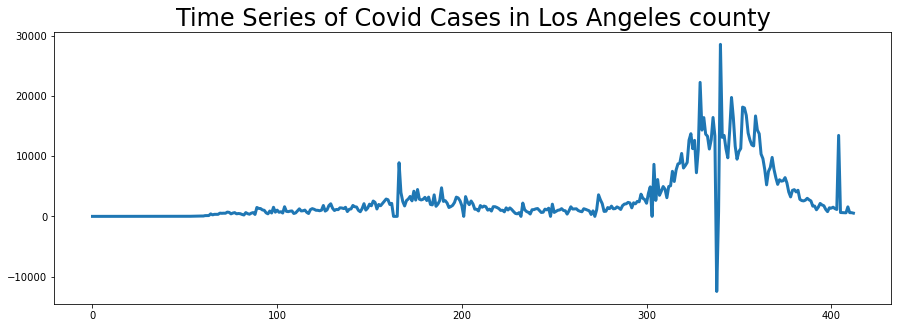

In [13]:
plt.figure(figsize=(15,5))
plt.plot(range(df['new_cases'].size), df['new_cases'], linewidth = 3)
plt.title('Time Series of Covid Cases in Los Angeles county', size = 24)

Text(0.5, 1.0, 'Autocorrelation Plot of Number of Covid Cases in Los Angeles county')

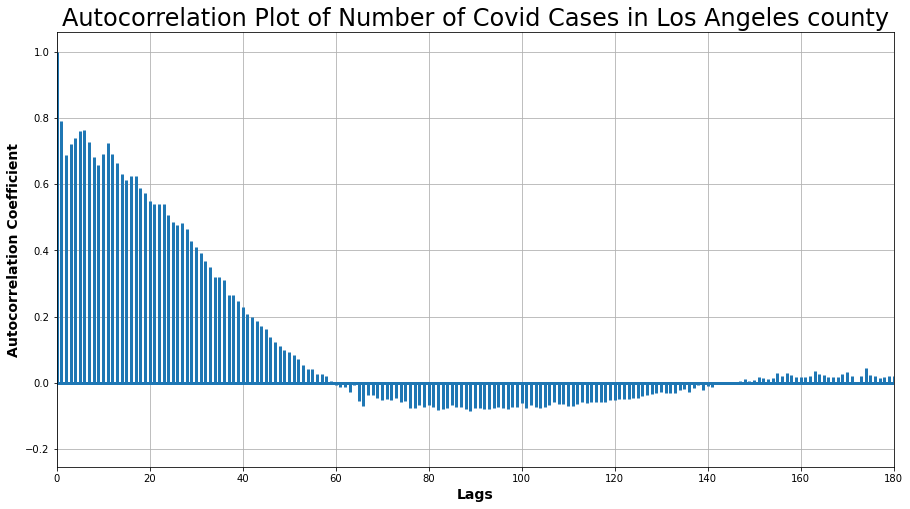

In [14]:
x = df['new_cases'] - df['new_cases'].mean() 
fig= plt.gcf()
fig.set_size_inches(15, 8)
plt.gca().acorr(x,usevlines=True, maxlags = 400, normed = True, lw = 3)
plt.gca().grid(True)
plt.gca().set_xlim(0,180)
plt.xlabel('Lags', size = 14, fontweight = 'bold')
plt.ylabel ('Autocorrelation Coefficient', size = 14, fontweight = 'bold')
plt.title('Autocorrelation Plot of Number of Covid Cases in Los Angeles county', size = 24)

<font size ="3"> Interpretation
> ACF of time series of Covid cases is Correlation of series with itself over shifted time periods. We shift time series by 1 lag, where each lag is 1 day and then we convolve it with original (unshifted) time series. Convolving simply means that we find the overlapping area in terms of percentage (%)

> For first 8 lags (each lag being 1 day), correlations remains high, above 0.8. This means that Covid cases reported for a given day are very similar in number to those that will be reported in subsequent 8 days! Knowing this insight could help LA county in policy and capacity planning. Interestingly, correlation remains weakly existent upto 30 days indicating a weak monthly pattern. But after about 60 days, the number of new cases is completely unrelated to those that were reported 2 months ago. Also, it is quite interesting to note that after 90 days, the cases are quite dissimilar. 
    
> This suggests there is no bi-monthly or quarterly pattern in time series, however there is evidence of a strong 10-day periodicity pattern. **"Number of cases" reported today could be used to make meaningful forecasts (of how bad it may get in LA) upto 8 days in advance.** After 8 days, it loses its predictive power and may lead to bad forecasting. This just goes to show how unpredictable it is to forecast as this virus was completely new to the world and LA and this makes it difficult for governments to plan anything for longer term. 

In [15]:
# ACF of time series of Covid cases is Correlation of series with itself over shifted time periods. 
# Shift series by 1 lag, where each lag is 1 day and then we convolve it with original series i.e find 
# overlapping area. how much overlap we have in terms of %....

# Interpretation
# For first 10 lags (each lag being 1 day), correlations remains high, above 0.8. This means that Covid cases 
# reported for a given day are very similar in number to those in subsequent 10 days. Knowing this could help 
# county in policy and capacity planning. Interestingly, correlation remains moderately strong upto 30 days 
# indicating a monthly trend but after about 60 days the number of cases is completely 
# unrelated to those that were reported 2 months ago. Also, it is quite interesting
# to note that after 90 days, the cases are quite dissimilar. Cases reported today could be used to make meaningful
# forecasts upto 10 days, but lose predictive power thereafter. This just goes to show how 
# unpredictable it is to forecast as this virus was completely new to the world and LA and this makes it difficult 
# for governments to plan anything for long term. 

<font size = "3"> Any time varying signal can be decomposd into a sum of periodic signals and white noise. We decompose the time series into its frequency components to see, is there any periodicity? If so, what is the contribution of various frequencies in the overall signal? So frequency could be every 1 day, every 2 days, every 10 days, etc.

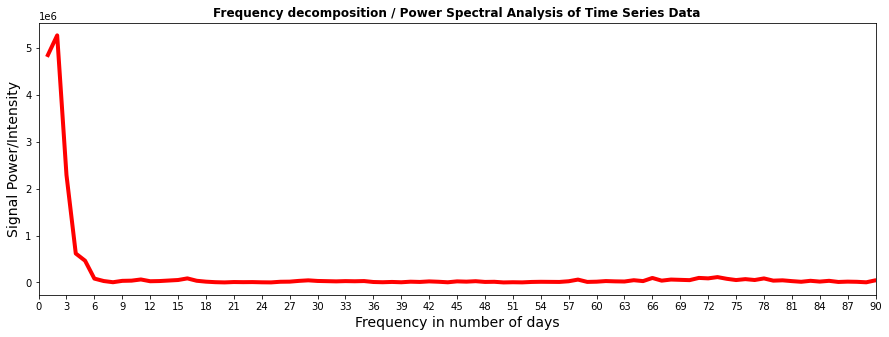

In [16]:
n = len(df['new_cases'])
freqs = fftfreq(n)   # creates all necessary frequencies
wave_number = freqs * n   # this is frequency of a wave in days. periodicity is very short.
mask = freqs > 0 # mask array to be used for power spectra. ignoring 1/2 of values as they are complex conjug of each other

fft_vals = fft(df['new_cases'])  # negative frequencies is a mathematical construct. makes no actual sense. do discard them
fft_theo = 2.0 * np.abs(fft_vals/n)  # 1/2 strength is on -ve side 1/2 on positive freq side so double it
power_spectrum = 2.0 * (np.abs(fft_vals/n)**2.0)
power_spectrum_variance = (power_spectrum / power_spectrum.var())*100
f = plt.figure(figsize=(15,5))
ax1 = f.add_subplot(111)
ax1.plot(wave_number[mask], power_spectrum[mask], label = "Power by Wave Number", color = 'red', linewidth = 4)
ax1.set_xlabel('Frequency in number of days', size = 14)
ax1.set_ylabel('Signal Power/Intensity', size = 14)
ax1.set_title('Frequency decomposition / Power Spectral Analysis of Time Series Data', size = 12, fontweight = 'bold')
ax1.set_xticks(np.arange(0, len(x)/2, 3))
ax1.set_xlim([0, 90])
plt.show()
f.subplots_adjust(hspace=15)

<font size = '3'> Above spectral analysis indicates that most of the frequencies in our time series are less than 6 days. Beyond 6 days, the contribution of higher frequency components is the low and flat indicating randomness/white noise. This aligns with our time series ACF plot insights.Afterall, spectral analysis is an orthogonal way of looking at patterns/periodicity in time series data! 




<font size="5"> Find Causal effect of Coronavirus on home prices in Los Angeles County

<font size="3"> Intuition:
    
> We hypothesize home prices to fall due to Covid. We think Covid may have led to weakened demand for houses, 
due to some people losing jobs hence moving to rental units, some people falling sick hence pausing their plans of buying new house (or upgrading to a bigger house), changes in attitudes towards perceived risk of real estate investing among other factors.  

<font size="3"> What is diff-in-diff (DiD) method?
    
> DiD method is a common statistical technique used to draw causal inferences from observational data. It calculates the causal effect of a treatment (Examples: sudden change like a new tax introduction or a Govt policy change or Covid hitting world, etc) on an outcome variable (e.g. median home price of single family homes) by comparing the average change over time in the outcome variable for the treatment group, compared to the average change over time for the control group.

> With the unexpected advent of Covid-19 in our county, it is reasonable to ask how it affected home prices. This is difficult to find out because in order to truly know how those home prices in our county were causally impacted, we need to consider how those home prices would be had the county never experienced Covid-19 (the counterfactual). However, the Covid-19 did hit the county and we never get to observe how those home prices would have fared without Covid-19. 
    
> DiD uses the outcome of the control group as a proxy / counterfactual for what would have occurred in the treatment group had there been no treatment. The difference in the average post-treatment outcomes between the treatment and control groups is a measure of the causal effect.

Datasets:
> The datasets we use to explore this question can be found here https://api.developer.attomdata.com/docs and https://usafacts.org/visualizations/coronavirus-covid-19-spread-map/state/california
    

In [17]:
# (*) Identify 2 counties (treatment and control) preferably in same state 
#     where Covid cases reached a threshold at 2 DIFFERENT points of time 
#     (Assumption: 10K cases, when ppl startes losing jobs and not when
#     1st case was reported...companies realized this virus is here to stay)

# (*) Los Angeles county hit 10,000 cases on 04/14/2020
#     San Francisco county hit 10,000 cases on 09/08/2020
#     If we define Treatment as a county hitting 10,000 cases, it means from 04/14/2020 to 09/08/2020, 
#     LA was in treatment period, but SF was not. 
#     Therefore, we pick LA as treatment group, SF as control group for DiD. 
#     To simplfy analyses, we pick a 1 month period from 04/14/2020 to 05/14/20 as post-treatment period, AND
#     04/14/2019 to 05/14/2019 as pre-treatment period. This allows us to make a YOY comparision at same points of
#     time 

# DEFINITIONS:
#  Outcome variable: Median Home Price of Single Family Residence (SFR) in US dollars. 


# Parallel Trends assumption(Untestable in practice) for DiD: We assume that if Covid had not hit, the time trend in Los Angeles would 
# match the time trend of San Francisco. This seems reasonable to us considering both are top counties in SAME state 
# and have many similarities. There is nothing unique to LA or SF county that changed over time. Anything that 
# confounder changes over time affects treatment (LA) and control (SF) group in the same way. i.e. there are no time-varying 
# LA or SF specific confounders i.e. anything that changes over time that might affect median home prices cannot systematically
# differ between LA and SF (treatment and control)

# In other words, we There are no systematic differences in the changes of unobserved confounders.

# Calculate simple Difference-in-Difference of Median Home Price of Single Family Homes as the causal effect of
# Covid on Home Prices in Los Angeles county

In [18]:
# Dask Bag filtering. Retains only those transactions in pre-treatment period for SingleFamilyResidences 
bag_losangeles_pre = bag_losangeles.filter(filters_preprocessing).filter(filter_dates_pre)  
bag_sanfrancisco_pre = bag_sanfrancisco.filter(filters_preprocessing).filter(filter_dates_pre)  

# Dask Bag filtering. Retains only those transactions in pre-treatment period for SingleFamilyResidences 
bag_losangeles_post = bag_losangeles.filter(filters_preprocessing).filter(filter_dates_post) 
bag_sanfrancisco_post = bag_sanfrancisco.filter(filters_preprocessing).filter(filter_dates_post) 

# Put above 4 Dask bags into a python list
bags = [bag_losangeles_pre, bag_sanfrancisco_pre, bag_losangeles_post, bag_sanfrancisco_post]

# Apply Dask Mapper function 
def median_generator(bag):
    bag = bag.map(extractor)   # Dask mapper used to extract sales price column
    L = list(bag)
    median = statistics.median(L)
    return median

median_la_pre, median_sf_pre,median_la_post,median_sf_post = [median_generator(bag) for bag in bags]    

In [19]:
print('Median home price of SingleFamilyHome in Los Angeles in pre-treatment period = {}'.format(median_la_pre))
print('Median home price of SingleFamilyHome in SanFrancisco in pre-treatment period = {}'.format(median_sf_pre))

print('Median home price of SingleFamilyHome in Los Angeles in post-treatment period = {}'.format(median_la_post))
print('Median home price of SingleFamilyHome in SanFrancisco in post-treatment period = {}'.format(median_sf_post))

Median home price of SingleFamilyHome in Los Angeles in pre-treatment period = 667250.0
Median home price of SingleFamilyHome in SanFrancisco in pre-treatment period = 1632500.0
Median home price of SingleFamilyHome in Los Angeles in post-treatment period = 665000.0
Median home price of SingleFamilyHome in SanFrancisco in post-treatment period = 1500000


In [20]:
causaleffect_percentage = ((median_la_post-median_la_pre)/median_la_pre) - ((median_sf_post - median_sf_pre)/median_sf_pre)
print ("The causal effect of Coronavirus on SFR home prices in Los Angeles = {} %)".format(causaleffect_percentage * 100))

The causal effect of Coronavirus on SFR home prices in Los Angeles = 7.779180965506637 %)


<font size="4"> Finding: *Covid-19 actually caused single family home prices in Los Angeles County to increase!*

<font size="3"> We would be interested in extending this causal analysis to more complex versions of DiD (like "*DiD Regression with Fixed Effects*" method) "to include multiple periods (instead of single month) and multiple counties (instead of just 1 treatment county and 1 control county). 
    
<font size="3">The <u>"*DiD regression with Fixed Effects*" </u>method would allow us to report standard error/robustness of causal inference. We could also combine *DiD* method with <u>*Nearest Neighbor Matching*</u> method. This would involve 'matching' known 'treatment' units with simulated counterfactual 'control' units: characteristically equivalent units which did not receive treatment. 
    
<font size="3">*However, it is our intent to restrict the scope of causal inference to "basic" Exploratory Data Analysis as per Milestone # 1 guidelines.*

In [21]:
# We would be interested in extending this causal analysis to more complex versions of DiD (like "*DiD Regression 
# with Fixed Effects*" method) "to include multiple periods (instead of single month) and multiple counties 
# (instead of just 1 treatment county and 1 control county). 
    
# The "*DiD regression with Fixed Effects*" method would allow us to report standard error/robustness of causal 
# inference. We could also combine *DiD* method with <u>*Nearest Neighbor Matching*</u> method. This would involve
# 'matching' known 'treatment' units with simulated counterfactual 'control' units: characteristically equivalent 
# units which did not receive treatment. 
    
# However, it is our intent to restrict the scope of causal inference to "basic" Exploratory Data Analysis as 
# per Milestone # 1 guidelines.